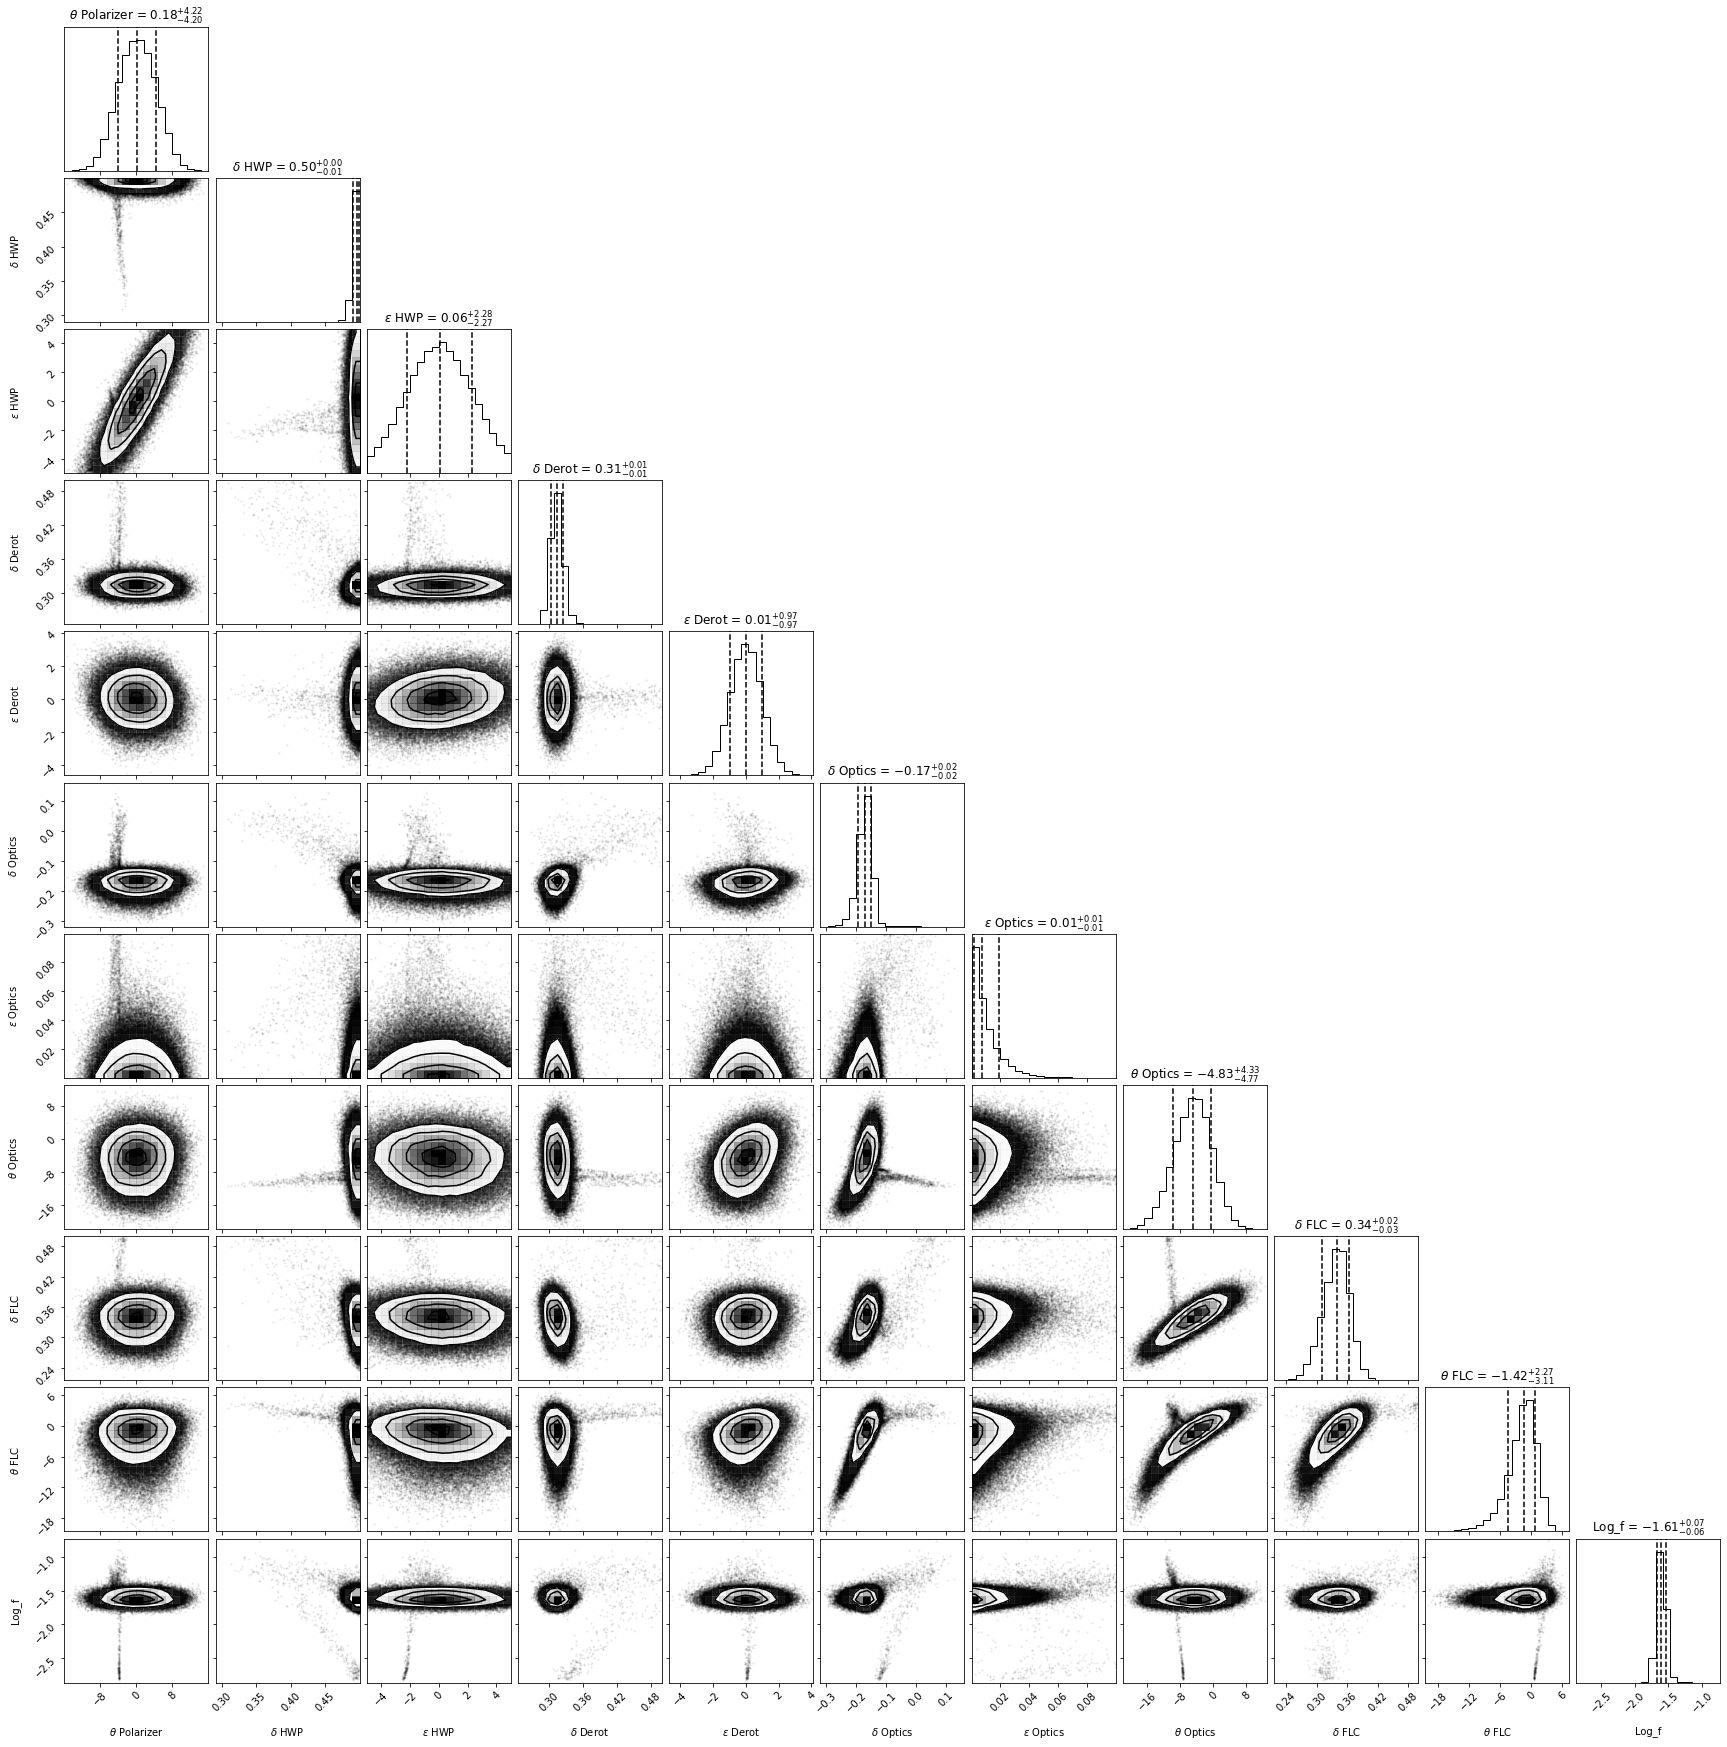

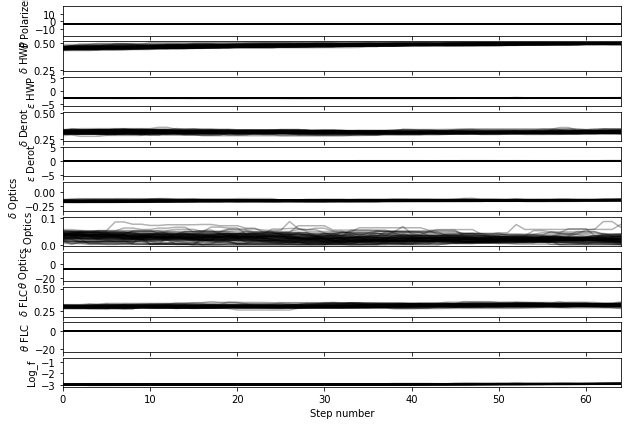

Median best-fit parameters: [[-1.40498975e-01  4.95423447e-01  2.01079318e-02  3.13165465e-01
   1.00453251e-01 -1.73591522e-01  7.00545675e-03 -4.97920864e+00
   3.38973824e-01 -1.63511811e+00 -1.61013023e+00]
 [ 1.18010207e-01  4.95732571e-01 -9.49530004e-02  3.14585327e-01
   2.66996680e-02 -1.70822991e-01  6.32616255e-03 -5.29990759e+00
   3.35814763e-01 -1.53856957e+00 -1.61100810e+00]
 [ 1.44432817e-01  4.95212479e-01  1.47377399e-01  3.14768725e-01
  -1.28535391e-01 -1.69820277e-01  8.06483433e-03 -5.23067186e+00
   3.37296759e-01 -1.65474440e+00 -1.60810303e+00]
 [ 3.36260584e-01  4.96330842e-01  1.02940258e-01  3.13972400e-01
   1.06286418e-01 -1.68312027e-01  7.66064406e-03 -4.58749761e+00
   3.40181845e-01 -1.17524186e+00 -1.60558471e+00]
 [-1.32678272e-02  4.95496001e-01 -2.32350167e-01  3.14081093e-01
  -1.73812387e-01 -1.71375118e-01  7.92071973e-03 -4.80880453e+00
   3.39667830e-01 -1.37327919e+00 -1.61006699e+00]
 [ 4.89346619e-01  4.96191513e-01  3.42973813e-01  3.1502

ValueError: too many values to unpack (expected 11)

In [2]:
import os
import sys
data_fitting_py_files_dir = os.path.abspath("../py_files/")
sys.path.insert(0, data_fitting_py_files_dir)
helper_func_py_files_dir = os.path.abspath("../../../vampires_on_sky_calibration/programs/py_files/")
sys.path.insert(0, helper_func_py_files_dir)

import numpy as np
import emcee
import h5py
import matplotlib.pyplot as plt
import corner
from multiprocessing import Pool
import instrument_matrices
import data_fitting as fitting

# Labels for the parameters
labels = [r"$\theta$ Polarizer", r"$\delta$ HWP", r"$\epsilon$ HWP", r"$\delta$ Derot", r"$\epsilon$ Derot",
          r"$\delta$ Optics", r"$\epsilon$ Optics", r"$\theta$ Optics", r"$\delta$ FLC", r"$\theta$ FLC", "Log_f"]

# Load the MCMC results from the .h5 file
filename = "../../data/20220428/675nm_Eleven_Parameter_Unswapped_FLCs_Fixed_Eta_Crv_EM_Gain_Four_Gaussian_Offsets_With_Logf_1_Deg_IMR_0_FLC_Scipy_Guess_MCMC_Fit_40000_Steps.h5"
backend = emcee.backends.HDFBackend(filename)

# Extract the chain and log_probabilities
samples = backend.get_chain(discard=100, thin=15, flat=True)
log_prob_samples = backend.get_log_prob(discard=100, thin=15, flat=True)

# Plot the corner plot
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

# Plot the Markov chains
nwalkers, nsteps, ndim = backend.get_chain().shape
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = backend.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Compute the median best-fit parameters
median_params = np.median(samples, axis=0)
print("Median best-fit parameters:", median_params)

# Plot the model with median best-fit parameters
delta_m3, epsilon_m3, offset_m3, em_gain = 0, 0, 0, 1 / 1.1342789620513443
fixed_params = [delta_m3, epsilon_m3, offset_m3, em_gain]
HWP_angs = np.array([0., 11.25, 22.5, 33.75, 45., 56.25, 67.5, 78.75])
IMR_angs = np.array([45., 57.5, 70., 82.5, 95., 107.5, 120., 132.5])

# Recreate the data and stds arrays used for plotting the model
data_dir = "../../data/20220428/"
index = 1
double_differences = np.load(data_dir + "double_difference_new_darks_median_grid.npy")[:, :, index]
double_sums = np.load(data_dir + "double_sum_new_darks_median_grid.npy")[:, :, index]
double_difference_errs = np.load(data_dir + "double_difference_sem_new_darks_median_grid.npy")[:, :, index]
double_sum_errs = np.load(data_dir + "double_sum_sem_new_darks_median_grid.npy")[:, :, index]
data = np.array([double_differences, double_sums])
stds = np.array([double_difference_errs, double_sum_errs])

model = instrument_matrices.full_system_mueller_matrix

# Calculate the model values using the median parameters
theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, log_f = median_params
all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
              delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
              rot_FLC, em_gain]

model_values = instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs)

# Plot the model vs. data
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(data[0].flatten(), label='Data')
ax[0].plot(model_values[0].flatten(), label='Model', linestyle='--')
ax[0].set_ylabel('Double Differences')
ax[0].legend()

ax[1].plot(data[1].flatten(), label='Data')
ax[1].plot(model_values[1].flatten(), label='Model', linestyle='--')
ax[1].set_ylabel('Double Sums')
ax[1].legend()

plt.xlabel('Data Points')
plt.show()
